In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
from data_util import *
from plot_util import *

In [2]:
savefig = False

## load velocity dispersion and velocity maps

In [3]:
snr_per_bin = 23
file_id = './data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}'.format(snr_per_bin)

binned_dispersion = np.loadtxt(file_id+'_mean.txt')
covariance = np.loadtxt(file_id+'_covariance.txt')


file_id = './data_products/systematic_marginalized_velocity_snr_per_bin_{}'.format(snr_per_bin)

binned_velocity = np.loadtxt(file_id+'_mean.txt')
covariance_velocity = np.loadtxt(file_id+'_covariance.txt')

In [4]:
covariance.shape

(41, 41)

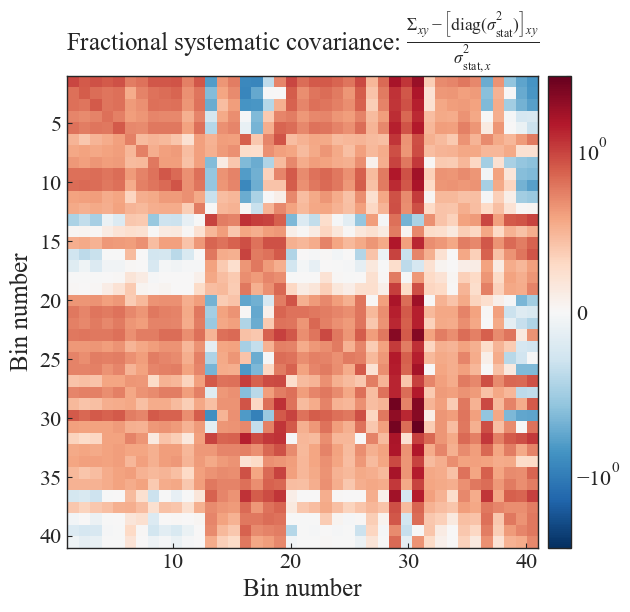

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import simple_norm
import paperfig as pf

pf.set_fontscale(2.)

fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2,
                                         height_ratio=1))
ax = fig.add_subplot(111)

def divide_matrix_by_array(a, b):
    a = a.copy()
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i, j] /= b[i]
    return a

vd_name = 'VD_wave_rng_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}.txt'.format(
        1, 3, 1, 'A', 23
    )

directory_measurements = "../kcwi_extractions/extracted_dispersions/"

url = directory_measurements + vd_name

extracted_vel_dis = np.loadtxt(url)

vel_dis = extracted_vel_dis[:, 1]
std_vel_dis = extracted_vel_dis[:, 3]

fractional_covariance = divide_matrix_by_array(
    covariance - np.diag(std_vel_dis**2), std_vel_dis**2)

# norm = simple_norm(fractional_covariance , 'linear', midpoint=0, clip=False)
from matplotlib.colors import SymLogNorm

im = ax.imshow(fractional_covariance, #norm=norm,
               norm=SymLogNorm(linthresh=0.03, linscale=0.03,
                               vmin=-5.0, vmax=5.0, base=10),
               cmap='RdBu_r', #vmax=5, vmin=-5,
               extent=[1, covariance.shape[0], covariance.shape[1], 1]
              ) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

# make a color map norm sqrt with symmetric range
# norm = simple_norm(fractional_covariance, 'sqrt', midpoint=0, clip=False)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
latex = r'$\frac{\Sigma_{xy} - \left[{\rm diag}(\sigma^2_{\rm stat})' \
        r'\right]_{xy}} ' \
        r'{\sigma^2_{\rm stat, \it x}}$'

cbar = fig.colorbar(im, cax=cax) #, label=latex)
# set colorbar ticks
cbar.set_ticks([-5, -1, 0, 1, 5])
ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

ax.set_title('Fractional systematic covariance: '+latex)
# ax.set_title('velocity dispersion covariance between Voronoi bins')
# ax.set_xticks([1, 10, 20, 30, 40])
# ax.set_yticks([1, 10, 20, 30, 40])

fig.tight_layout()

if savefig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_covariance.pdf', 
                bbox_inches='tight'
               )

In [157]:
np.median(np.diag(fractional_covariance))

0.4730851722981984

In [6]:
covariance.shape

(41, 41)

### Load bin mapping

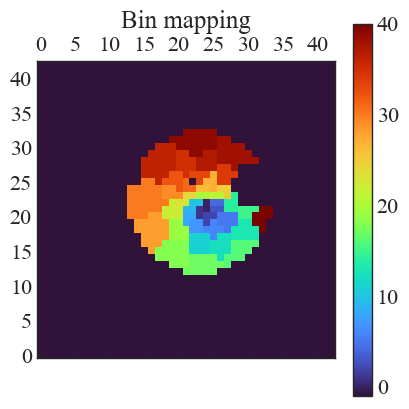

In [7]:
%matplotlib inline

bin_mapping = load_bin_mapping(target_snr_per_bin=snr_per_bin, plot=True);


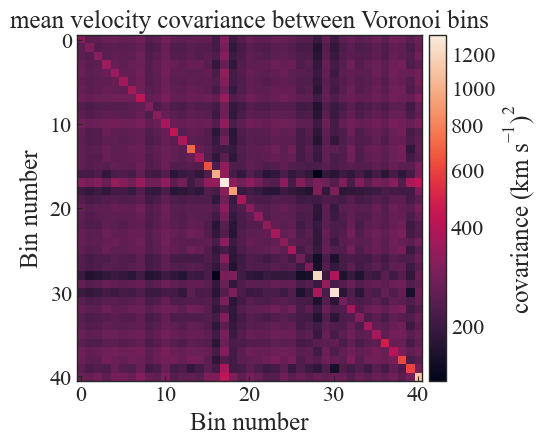

In [8]:
norm = simple_norm(covariance_velocity, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((covariance_velocity), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

ax.set_title('mean velocity covariance between Voronoi bins')
fig.tight_layout()

Text(0.5, 1.0, 'Mean velocity')

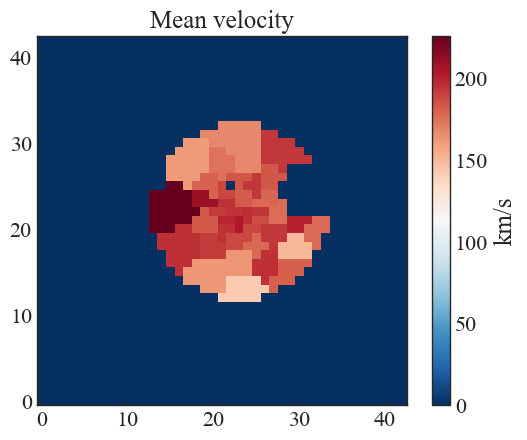

In [9]:
plt.imshow(get_kinematics_maps(binned_velocity, bin_mapping), origin='lower', cmap='RdBu_r')
plt.colorbar(label='km/s')
plt.title('Mean velocity')

# Fit PA and mean systematic velocity

#### First, I create a covariance matrix for mean velocity map for each spaxel (not in Voronoi bins). This covariance matrix is provided to `fit_kinematic_pa` for uncertainty estimation.

In [11]:
velocity_realizations = []

N = 3000

for i in tqdm_notebook(range(N)):
    binned_velocity_realization = np.random.multivariate_normal(mean=binned_velocity, 
                                                                cov=covariance_velocity) #np.loadtxt(file_id+'_mean.txt')

    V_2d_realization = get_kinematics_maps(binned_velocity_realization, bin_mapping)

    V_2d_realization[bin_mapping == -1] = np.nan

    V_2d_flat_realization = V_2d_realization.flatten()
    V_2d_flat_realization = V_2d_flat_realization[~np.isnan(V_2d_flat_realization)]
    
    velocity_realizations.append(V_2d_flat_realization)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_29556/420121926.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


  0%|          | 0/3000 [00:00<?, ?it/s]

In [13]:
V_2d_cov = np.cov(velocity_realizations, rowvar=False)

In [14]:
V_2d_cov.shape

(302, 302)

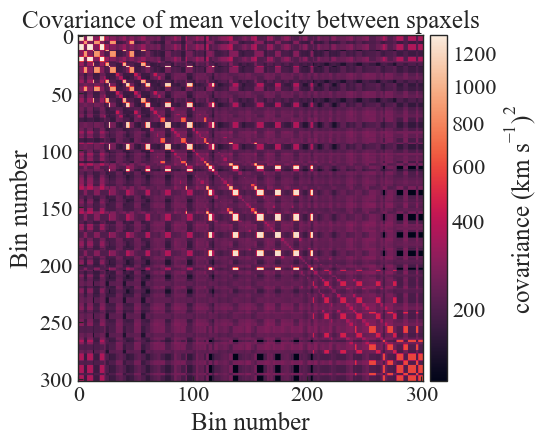

In [51]:
norm = simple_norm(V_2d_cov, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((V_2d_cov), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

ax.set_title('Covariance of mean velocity between spaxels')
fig.tight_layout()

In [16]:
V_2d = get_kinematics_maps(binned_velocity, bin_mapping)
dV_2d = np.sqrt(get_kinematics_maps(np.diag(covariance_velocity), bin_mapping))

V_2d[bin_mapping == -1] = np.nan
dV_2d[bin_mapping == -1] = np.nan

In [52]:
X_GRID, Y_GRID = np.meshgrid(
        -1 * np.arange(-3.0597, 3.1597, 0.1457),
        np.arange(-3.0597, 3.1597, 0.1457),
    )

PIXEL_SIZE = 0.1457
X_CENTER = -(23.29 - 21.) * PIXEL_SIZE  # 23.5
Y_CENTER = (22.23 - 21.) * PIXEL_SIZE  # 21.5

X_GRID -= X_CENTER
Y_GRID -= Y_CENTER

x_grid = np.copy(X_GRID)
y_grid = np.copy(Y_GRID)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:05<00:00, 62.60it/s]


  Kin PA: 135.0  +/-  89.8  (3*sigma error)
Velocity Offset: 182.31


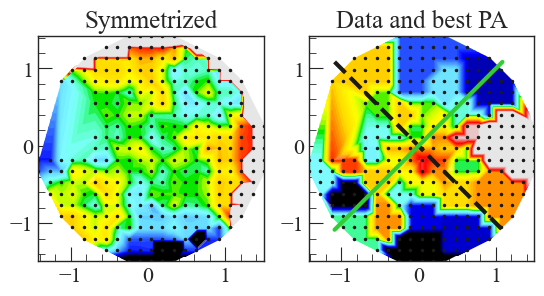

In [53]:
from pafit.fit_kinematic_pa import fit_kinematic_pa

V_2d_flat = V_2d.flatten()
dV_2d_flat = dV_2d.flatten()[~np.isnan(V_2d_flat)]
x_grid_flat = x_grid.flatten()[~np.isnan(V_2d_flat)]
y_grid_flat = y_grid.flatten()[~np.isnan(V_2d_flat)]
V_2d_flat = V_2d_flat[~np.isnan(V_2d_flat)]

plot = True
pa, sigma_pa, v_mean = fit_kinematic_pa(x_grid_flat, y_grid_flat, V_2d_flat,
                          quiet=False, plot=plot, dvel=dV_2d_flat, covariance_matrix=V_2d_cov)


In [58]:
print("PA: {:.0f}±{:.0f} degree".format(pa, sigma_pa/3.))
print("v_mean: {:.2f} km/s".format(v_mean))

PA: 135±30 degree
v_mean: 182.31 km/s


#### The kinematic PA is not well-constrained. So, we will use a population prior from Li et al. (2018) get the probability of oblateness, instead of measuring it directly from the kinematic PA of the system itself.

## Get oblateness probability

In [30]:
## these values are scrappd from Li et al. (2008), Fig 1, for slow rotators

# mean of delta_pa
delta_pa = np.array([
    2.6038461538461535,
    1.603846153846154,
    1.1,
    1.103846153846154,
    1.5038461538461538,
    1.3038461538461537,
    2.1038461538461535,
    2.6038461538461535,
    2.9038461538461537,
    3.407692307692307,
])


# upper 1sigma limit of delta_pa
delta_pa_high = np.array([
    3.2076923076923074,
    1.9038461538461555,
    1.353846153846154,
    1.4038461538461484,
    1.8038461538461554,
    1.611538461538463,
    2.5038461538461547,
    3.0076923076923077,
    3.3038461538461537,
    3.853846153846153
])

delta_pa_uncertainty = (delta_pa_high - delta_pa)

In [31]:
# sampling points of delta_pa in Li et al. (2018)

bar_points = np.linspace(-90, 90, 20)
bar_points_half = ((bar_points[1:] + bar_points[:-1]) / 2.)[-10:]

bar_points_half[0] = 0

bar_points_half = 90 - bar_points_half

bar_points_half

array([90.        , 80.52631579, 71.05263158, 61.57894737, 52.10526316,
       42.63157895, 33.15789474, 23.68421053, 14.21052632,  4.73684211])

#### We fit a double Gaussian model to the points from Li et al. (2018).

In [32]:
def double_gaussian_model(x, params):
    """
    Double Gaussian function to optimize with means set to 0 and 90 degrees
    """
    amp1, sig1, amp2, sig2 = params
    
    density = amp1 * np.exp(-x**2/2./sig1**2) \
            + amp2 * np.exp(-(90-x)**2/2./sig2**2)
    
    return density


def cost_function(params):
    """
    Chi^2 for the double gaussian model
    """
    amp1, sig1, amp2, sig2 = params
    
    density = double_gaussian_model(bar_points_half, params)
    
    return 0.5 * np.sum((density  - delta_pa)**2 / delta_pa_uncertainty**2)

In [33]:
from scipy.optimize import minimize 

res = minimize(cost_function, x0=[2.5, 15, 3.2, 35])

res

      fun: 1.85961484657602
 hess_inv: array([[ 9.54679141e-02, -1.23070335e+00, -1.66743407e-02,
         6.47104013e-01],
       [-1.23070335e+00,  2.96753385e+01,  5.82929075e-01,
        -1.88297237e+01],
       [-1.66743407e-02,  5.82929075e-01,  2.41642350e-01,
        -1.38774075e+00],
       [ 6.47104013e-01, -1.88297237e+01, -1.38774075e+00,
         2.04075580e+01]])
      jac: array([-9.08970833e-07,  1.19209290e-07,  6.40749931e-07,  2.98023224e-07])
  message: 'Optimization terminated successfully.'
     nfev: 165
      nit: 30
     njev: 33
   status: 0
  success: True
        x: array([ 3.16941273, 38.04950416,  2.00350823, 11.54806274])

#### Normalizing the fitted double Gaussian probability function by dividing out the total integrated area.

In [34]:
from scipy.integrate import quad

normalizing_factor = quad(double_gaussian_model, 0, 90, args=(res.x))[0] / 90

In [35]:
import copy

double_gauss_params = copy.deepcopy(res.x)

double_gauss_params[0] /= normalizing_factor
double_gauss_params[2] /= normalizing_factor

In [37]:
oblate_prob = quad(double_gaussian_model, 0, 45, args=(double_gauss_params))[0] / 90
prolate_prob = quad(double_gaussian_model, 45, 90, args=(double_gauss_params))[0] / 90

print('Probability of oblateness: {:.2f}'.format(oblate_prob))

Probability of oblateness: 0.65


## Make plot

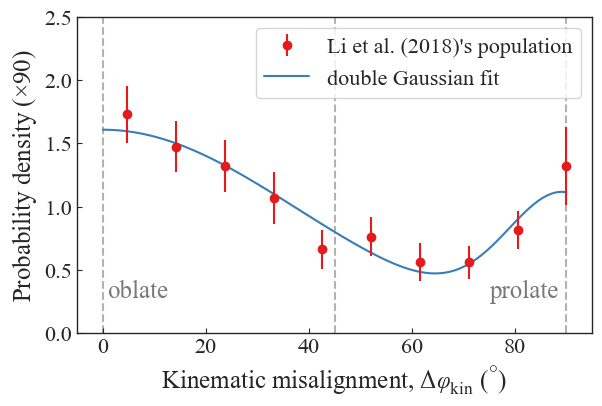

In [40]:
import copy


fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))
ax = fig.add_subplot(111)

xs = np.linspace(0, 90, 100)
ax.plot(xs, double_gaussian_model(xs, double_gauss_params), c=pf.cb_blue, label='double Gaussian fit')

oblate_component = copy.deepcopy(res.x)
prolate_component = copy.deepcopy(res.x)
prolate_component[2] = 0
oblate_component[0] = 0


ax.set_ylim(0, 2.5)
ax.set_xlim(-5, 95)

ax.errorbar(bar_points_half, delta_pa/normalizing_factor, 
            yerr=delta_pa_uncertainty/normalizing_factor, 
            ls='None', marker='o', 
            color=pf.cb_red, label='Li et al. (2018)\'s population'
            )

ax.axvline(0, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(45, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(90, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)

ax.set_xlabel(r'Kinematic misalignment, $\Delta \varphi_{\rm kin}$ (${}^{\circ}$)')
ax.set_ylabel(r'Probability density (${\times 90}$)')


t = ax.text(.8, .5/160.5*90, 'oblate', color=pf.cb_grey, alpha=0.7)
t = ax.text(75., .5/160.5*90, 'prolate', color=pf.cb_grey, alpha=0.7)


handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right')

if savefig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/oblateness_prior_population.pdf',
                bbox_inches='tight'
               )

# Plot dispersion and mean velocity maps

307.6204948319062 222.98102731129964


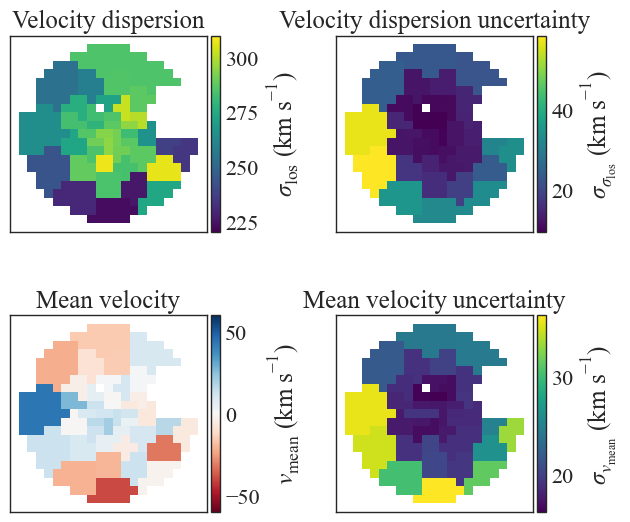

In [87]:
import matplotlib.colors as colors

pf.set_fontscale(2)

# cmap = palettable.cubehelix.perceptual_rainbow_16.mpl_colormap

vmax, vmin = 365, 55
mid = 265 #(vmax + vmin) / 2.
f = 25


def _forward(x):
    return np.arctan((x - mid)/f)


def _inverse(x):
    return np.tan(x)*f + mid


norm = colors.FuncNorm((_forward, _inverse), vmin=vmin, vmax=vmax)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=pf.get_fig_size(width=pf.mnras_colwidth*2, height_ratio=1))

# extent = [15:38, 15:38]
VD_2d = get_kinematics_maps(binned_dispersion, bin_mapping)
dVD_2d = get_kinematics_maps(np.sqrt(np.diag(covariance)), bin_mapping)

dVD_2d[VD_2d == 0] = np.nan
VD_2d[VD_2d == 0] = np.nan

vmax, vmin = np.nanmax(VD_2d), np.nanmin(VD_2d)
print(vmax, vmin)
vmax, vmin = 310, 220

im = axes[0][0].imshow(VD_2d[11:34, 12:35], cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) #, norm=norm)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{\rm los}$ (km s$^{-1}$)', #ticks=[350, 300, 250, 200, 0]
                   )
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('Velocity dispersion')

im = axes[0][1].imshow(dVD_2d[11:34, 12:35], cmap='viridis', origin='lower') #, extent=extent)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{\sigma_{\rm los}}$ (km s$^{-1}$)')
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[0][1].set_title('Velocity dispersion uncertainty')

im = axes[1][0].imshow((V_2d-v_mean)[11:34, 12:35], cmap='RdBu', origin='lower', vmax=60, vmin=-60) #, extent=extent)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$v_{\rm mean}$ (km s$^{-1}$)')
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][0].set_title('Mean velocity')

im = axes[1][1].imshow(dV_2d[11:34, 12:35], cmap='viridis', origin='lower') #, extent=extent)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{v_{\rm mean}}$ (km s$^{-1}$)')
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][1].set_title('Mean velocity uncertainty')


fig.tight_layout()
plt.subplots_adjust(wspace=.55, hspace=-.1)

if savefig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_maps.pdf', 
                bbox_inches='tight'
               )

# Plot radial profile of velocity dispersion profile

In [10]:
from dynamical_model import DynamicalModel

dyn_model = DynamicalModel('powerlaw')

In [96]:
from lenstronomy.LightModel.light_model import LightModel
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from dynamical_model import DynamicalModel
from lenstronomy.Util.param_util import phi_q2_ellipticity

light_model = LightModel(['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])
dyn_model = DynamicalModel('powerlaw')

supersampling_factor = 5

x_grid, y_grid = np.meshgrid(
    np.linspace(-2.5, 2.5, 500),
    np.linspace(-2.5, 2.5, 500)
)

kwargs_light = dyn_model.get_double_sersic_kwargs(is_shperical=True)

kwargs_light[0]['center_x'] = 0
kwargs_light[0]['center_y'] = 0
kwargs_light[1]['center_x'] = 0
kwargs_light[1]['center_y'] = 0

e1, e2 = phi_q2_ellipticity(0, 0.87)
kwargs_light[0]['e1'] = e1
kwargs_light[0]['e2'] = e2

e1, e2 = phi_q2_ellipticity(0, 0.85)
kwargs_light[1]['e1'] = e1
kwargs_light[1]['e2'] = e2

num_pix = len(x_grid)

surface_brightness = light_model.surface_brightness(x_grid.flatten(),
                                                    y_grid.flatten(),
                                                    kwargs_light).reshape(x_grid.shape)

sigma = dyn_model.PSF_FWHM / 2.355 / dyn_model.PIXEL_SIZE * supersampling_factor

kernel = Gaussian2DKernel(x_stddev=sigma,
                          x_size=4 * int(sigma) + 1,
                          y_size=4 * int(sigma) + 1)

convolved_surface_brightness = convolve(surface_brightness, kernel)


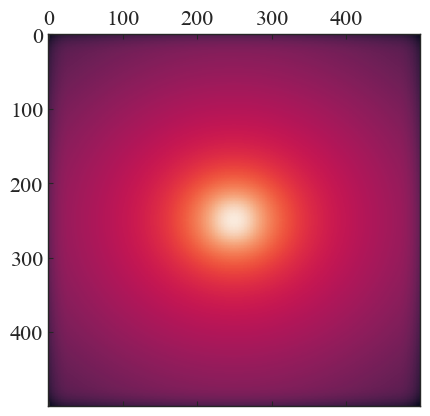

In [97]:
# interpolate from 2d image
from scipy.interpolate import interp2d

interp = interp2d(x_grid[0, :],
                  y_grid[:, 0],
                  convolved_surface_brightness)

plt.matshow(np.log10(interp(x_grid[0, :], y_grid[:, 0])))

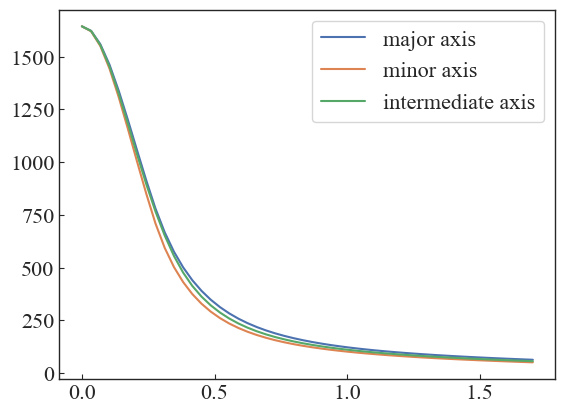

In [104]:
r = np.linspace(0., 1.7, 50)

major_axis_light = interp(r, 0)
minor_axis_light = interp(0, r).squeeze()
intermediate_axis_light = np.diag(interp(r*np.cos(np.pi/4), r*np.sin(np.pi/4)))

plt.plot(r, major_axis_light, label='major axis')
plt.plot(r, minor_axis_light, label='minor axis')
plt.plot(r, intermediate_axis_light, label='intermediate axis')
plt.legend()

In [105]:
def get_profiles(xs, ys, shape, moment='zz', params=None):
    """
    """
    if params is None:
        if shape == 'prolate':
            params = prolate_params
        else:
            params = oblate_params
        
    theta_e, gamma, q, D_dt, inclination, kappa_ext, lambda_int, D_d, ani_param = params
    lens_params = [theta_e, gamma, q]
    cosmo_params = [lambda_int, kappa_ext, D_dt/(1-kappa_ext)/lambda_int, D_d]
        
    return dyn_model.compute_jampy_v_rms_model(lens_params, 
                                               cosmo_params,
                                               ani_param=ani_param,
                                               inclination=inclination,
                                               anisotropy_model='constant',
                                               moment=moment,
                                               x_points=xs, y_points=ys,
                                               shape=shape
                                              )

def get_radial_profile(params, shape):
    """
    Make radial profile by averaging over major, minor, and intermediate axes.
    """
    sigma_r = get_profiles(r*np.cos(np.pi/4), r*np.sin(np.pi/4), shape,
                           'zz', params=params)**2 * intermediate_axis_light
    sigma_r += get_profiles(r, 0*r, shape, 'zz', params=params)**2 * minor_axis_light
    sigma_r += get_profiles(0*r, r, shape, 'zz', params=params)**2 * major_axis_light

    total_light = major_axis_light + minor_axis_light + intermediate_axis_light
    
    return np.sqrt(sigma_r / total_light)

In [106]:
import h5py as h5
from plot_util import *

with h5.File('./data_products/radially_binned_dispersion.h5', 'r') as f:
    radially_binned_dispersion = np.array(f['binned_dispersion'])
    radial_bins = np.array(f['radial_bins'])
    covariance_radial_bins = np.array(f['covariance'])

In [107]:
oblate_prob = 0.65

In [108]:
N = 100

N_obl = int(oblate_prob * N)
N_pro = int((1 - oblate_prob) * N)

radial_profiles_oblate = []
radial_profiles_prolate = []

oblate_chain = get_chain('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='oblate', burnin=-400)
prolate_chain = get_chain('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='prolate', burnin=-400)

np.random.seed(4)
random_indexes_obl = np.random.randint(low=0, high=oblate_chain.shape[0], size=N_obl)
random_indexes_pro = np.random.randint(low=0, high=prolate_chain.shape[0], size=N_pro)


for i in range(N_obl):
    params = oblate_chain[random_indexes_obl[i], :]
    radial_profiles_oblate.append(get_radial_profile(params, 'oblate'))

for i in range(N_pro):
    params = prolate_chain[random_indexes_pro[i], :]
    radial_profiles_prolate.append(get_radial_profile(params, 'prolate'))

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 

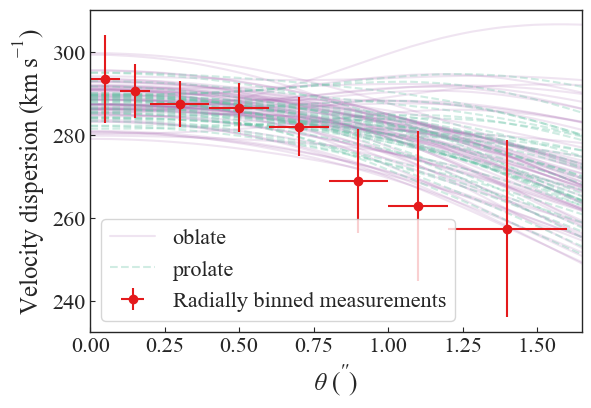

In [111]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=0.3))

ax = fig.add_subplot(122)

ax.errorbar(x=(radial_bins[:-1]+np.diff(radial_bins)/2.), 
            y=radially_binned_dispersion, 
            xerr=np.diff(radial_bins)/2,
            yerr=np.sqrt(np.diag(covariance_radial_bins)),
            color=pf.cb_red,
            ls='None', marker='o', label='Radially binned measurements'
           )
    
for i in range(len(radial_profiles_oblate)):
    if i == 0:
        ax.plot(r, radial_profiles_oblate[i], c=pf.cb_purple, alpha=0.15, zorder=-20, label='oblate')
    else:
        ax.plot(r, radial_profiles_oblate[i], c=pf.cb_purple, alpha=0.15, zorder=-20)
    
for i in range(len(radial_profiles_prolate)):
    if i == 0:
        ax.plot(r, radial_profiles_prolate[i], c=pf.cb2_emerald, alpha=0.3, ls='--', label='prolate', zorder=-10)
    else:
        ax.plot(r, radial_profiles_prolate[i], c=pf.cb2_emerald, alpha=0.3, ls='--', zorder=-10)
        
# params = get_most_likely_value('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='prolate', burnin=-300)
# ax.plot(r, get_radial_profile(params, 'prolate'), lw='2', zorder=-10)

ax.set_xlabel(r'$\theta$ ($^{\prime\prime}$)')
ax.set_ylabel(r'Velocity dispersion (km s${}^{-1}$)')
ax.legend()
ax.set_xlim(0, 1.65)

# # ax.legend()

if savefig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/radial_velocity_dispersion.pdf', 
                bbox_inches='tight'
               )

# Plot intrinsic q prior

In [26]:
xs = np.linspace(0, 1, 100)

kinematic_likelihood = KinematicLikelihood('powerlaw', shape='oblate')
intrinsic_q_oblate = kinematic_likelihood.get_intrinsic_q_prior(xs)

kinematic_likelihood = KinematicLikelihood('powerlaw', shape='prolate')
intrinsic_q_prolate = kinematic_likelihood.get_intrinsic_q_prior(xs)

/Users/ajshajib/Research/RXJ1131_KCWI/RXJ1131_KCWI_kinematics/kinematics_likelihood.py:239: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


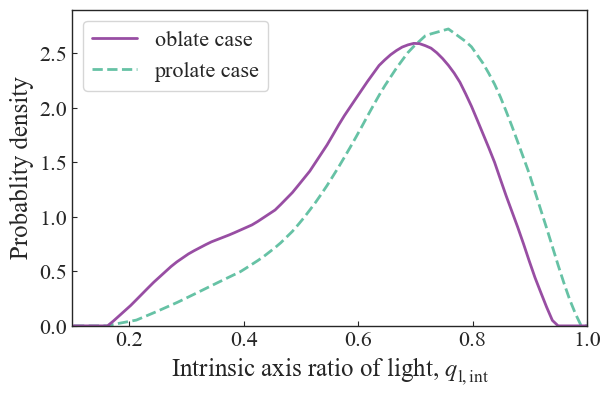

In [28]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))

ax = fig.add_subplot(111)

ax.plot(xs, np.exp(intrinsic_q_oblate), label='oblate case', color=pf.cb_purple, lw=2, ls='-')
ax.plot(xs, np.exp(intrinsic_q_prolate), label='prolate case', color=pf.cb2_emerald, zorder=-2, lw=2, ls='--')

ax.set_xlabel(r'Intrinsic axis ratio of light, $q_{\rm l, int}$')
ax.set_ylabel(r'Probablity density')
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 2.9)
# ax.set_yticklabels([])
ax.legend()

if savefig:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/q_intrinsic_prior.pdf', 
                bbox_inches='tight'
               )